In [1]:
import pandas as pd

from utlis import *
from model import *
from dataset import *
from metrics import *

from collections import Counter
from collections import defaultdict
from torch.utils.data import DataLoader
from poprogress import simple_progress as simp

In [2]:
import matplotlib.pyplot as plt

In [31]:
# load data
all_data = pd.read_csv("../data_preprocess/all-data.csv")
all_len = len(all_data)
print("all_len: ",all_len)

# split data
train_data, valid_data, test_data = split_dataset(all_data, 0.8, 0.1)
print("train_data_size: ",len(train_data))
print("valid_data_size: ",len(valid_data))
print("test_data_size: ",len(test_data))
print("Spliting data done")
print("-"*30)

# get unique labels
label_unique = sorted(get_label_unique(train_data))

# get dicts
label_to_id = {k: v for v,k in enumerate(label_unique)}
id_to_label = {k: v for k,v in enumerate(label_unique)}
print(label_to_id)
print(id_to_label)

# get seq
train_token_seq, train_label_seq = get_data_seq(train_data)
valid_token_seq, valid_label_seq = get_data_seq(valid_data)
test_token_seq, test_label_seq = get_data_seq(test_data)
print("Get sequences done")
print("-"*30)

# get token -> id and label -> id
token2cnt = Counter([token for sentence in train_token_seq for token in sentence])
label_set = sorted(set(label for sentence in train_label_seq for label in sentence))
token_to_id = get_token2id(token2cnt)
print("Encoding data done")
print("size: ",len(token_to_id))
print("-"*30)

# dataset
train_set = nerDataset(train_token_seq, train_label_seq, token_to_id, label_to_id, preprocess=True)
valid_set = nerDataset(valid_token_seq, valid_label_seq, token_to_id, label_to_id, preprocess=True)
test_set = nerDataset(test_token_seq, test_label_seq, token_to_id, label_to_id, preprocess=True)
print("Making datasets done")
print("-"*30)

# dataloader
train_coll_fn = nerCollator(token_to_id["<UNK>"], label_to_id["O"], 100)
valid_coll_fn = nerCollator(token_to_id["<UNK>"], label_to_id["O"], 100)
test_coll_fn = nerCollator(token_to_id["<UNK>"], label_to_id["O"], 100)
bz = 64
train_loader = DataLoader(dataset=train_set, batch_size=bz, shuffle=False, collate_fn=train_coll_fn)
valid_loader = DataLoader(dataset=valid_set, batch_size=bz, shuffle=False, collate_fn=valid_coll_fn)
test_loader = DataLoader(dataset=test_set, batch_size=bz, shuffle=False, collate_fn=test_coll_fn)
print("Making Dataloaders done")
print("-"*30)


all_len:  21363
train_data_size:  17142
valid_data_size:  2085
test_data_size:  2136
Spliting data done
------------------------------


100%|██████████| 17142/17142 [00:00<00:00, 125692.08it/s]

{'B-LOC': 0, 'B-MISC': 1, 'B-ORG': 2, 'B-PER': 3, 'I-LOC': 4, 'I-MISC': 5, 'I-ORG': 6, 'I-PER': 7, 'O': 8}
{0: 'B-LOC', 1: 'B-MISC', 2: 'B-ORG', 3: 'B-PER', 4: 'I-LOC', 5: 'I-MISC', 6: 'I-ORG', 7: 'I-PER', 8: 'O'}


Get sequences done
------------------------------
Encoding data done
size:  25232
------------------------------
Making datasets done
------------------------------
Making Dataloaders done
------------------------------


In [4]:
embedding_layer = Embedding(num_embeddings=len(token_to_id), embedding_dim=128)

rnn_layer = dynamicRNN(rnn_unit=torch.nn.LSTM, input_size=128, hidden_size=256, 
                num_layers=1, dropout=0, bidirectional=True)

linear_head = LinearHead(linear_head=torch.nn.Linear(in_features=(2*256), 
                                                     out_features=len(label_to_id)))

model = BiLSTM(embedding_layer=embedding_layer, rnn_layer=rnn_layer, linear_head=linear_head)#.to(device)
print("Setting models done")
print("-"*30)

Setting models done
------------------------------


In [25]:
criterion = torch.nn.CrossEntropyLoss(reduction="none")
optimizer_type = torch.optim.Adam
optimizer = optimizer_type(params=model.parameters(), lr=0.001, amsgrad=False)
print("Setting metrics done")
print("-"*30)

verbose = False
n_epoch = 1
clip_grad_norm = 0.8
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Setting metrics done
------------------------------


In [26]:
def data_epoch(model, dataloader, criterion, mode, device, verbose=True):
    metrics = defaultdict(list)
    if mode == "train":
        model.train()
    else:
        model.eval()
        
    for tokens, labels, lengths in simp(dataloader):
        tokens, labels, lengths = (tokens.to(device), labels.to(device), lengths.to(device))

        mask = masking(lengths)

        # forward pass
        if mode == "train":
            logits = model(tokens, lengths) # bz,xxx,9
            loss_without_reduction = criterion(logits.transpose(-1, -2), labels)
            loss = torch.sum(loss_without_reduction * mask) / torch.sum(mask)
            # backward pass
            loss.backward()
            # gradient clipping
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_grad_norm, norm_type=2)
            # update 
            optimizer.step()
            optimizer.zero_grad()
            
        else:
            with torch.no_grad():
                logits = model(tokens, lengths)
                loss_without_reduction = criterion(logits.transpose(-1, -2), labels)
                loss = torch.sum(loss_without_reduction * mask) / torch.sum(mask)

        # make predictions
        y_true = to_numpy(labels[mask])
        y_pred = to_numpy(logits.argmax(dim=-1)[mask])

        # calculate metrics
        metrics = calculate_metrics(
            metrics=metrics,
            loss=loss.item(),
            y_true=y_true,
            y_pred=y_pred,
            idx2label=id_to_label,
        )

    return metrics

In [27]:
for epoch in range(n_epoch):
    train_metrics = data_epoch(model, train_loader, criterion, "train", device, False)
    valid_metrics = data_epoch(model, valid_loader, criterion, "valid", device, False)
    print("t ",np.mean(train_metrics["loss"]))
    print("v ",np.mean(valid_metrics["loss"]))
test_metrics = data_epoch(model, test_loader, criterion, "test", device, False)

100%|██████████| 35/35 [00:05<00:00,  6.33it/s]


t  1.5360968260282881
v  1.5018926995141166


100%|██████████| 2146/2146 [00:35<00:00, 59.72it/s] 


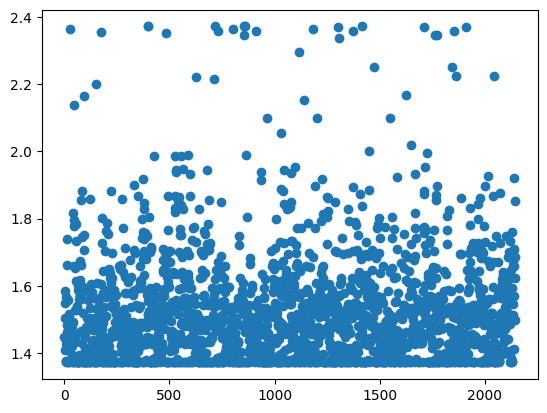

In [28]:
y0 = train_metrics["loss"]
y1 = valid_metrics["loss"]
y2 = test_metrics["loss"]
x = y2
plt.scatter([range(len(x))], x)


In [29]:
# print(train_metrics["loss"])
# print(valid_metrics["loss"])
# print(test_metrics["loss"])

In [30]:
sent = "Blair Larsen or the uncapped Glenn Taylor are on standby to replace Jones and , with Jonah Lomu out of action with a shoulder injury picked up in Tuesday 's drawn match against Griqualand West , Eric Rush is favourite to play should Wilson fail to recover ."

# sent = "June 25-27 v British Universities ( at Oxford , three days )"
sent = sent.lower().split()
sent_tokens = []
for x in sent:
    sent_tokens.append(token_to_id.get(x, 1))
model.eval()
in_tokens = torch.tensor(sent_tokens).unsqueeze(0).to(device)
in_length = torch.tensor([len(sent_tokens)]).to(device)

cc = np.argmax(to_numpy(model(in_tokens, in_length)[0]),1)
ou_labels = []
ou_dict = {}
for i,x in enumerate(cc):    
    # print({sent[i]: id_to_label[x]})
    ou_dict[sent[i]] = id_to_label[x]
    ou_labels.append(id_to_label[x])
ou_dict

{'blair': 'O',
 'larsen': 'B-PER',
 'or': 'O',
 'the': 'O',
 'uncapped': 'O',
 'glenn': 'B-PER',
 'taylor': 'B-LOC',
 'are': 'O',
 'on': 'O',
 'standby': 'O',
 'to': 'O',
 'replace': 'B-PER',
 'jones': 'B-LOC',
 'and': 'O',
 ',': 'O',
 'with': 'O',
 'jonah': 'B-PER',
 'lomu': 'B-PER',
 'out': 'O',
 'of': 'O',
 'action': 'O',
 'a': 'O',
 'shoulder': 'O',
 'injury': 'O',
 'picked': 'O',
 'up': 'O',
 'in': 'O',
 'tuesday': 'O',
 "'s": 'O',
 'drawn': 'O',
 'match': 'O',
 'against': 'O',
 'griqualand': 'B-PER',
 'west': 'B-LOC',
 'eric': 'B-PER',
 'rush': 'O',
 'is': 'O',
 'favourite': 'O',
 'play': 'O',
 'should': 'O',
 'wilson': 'B-PER',
 'fail': 'O',
 'recover': 'O',
 '.': 'O'}